In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/MyDrive/Uni/StudyProject_CMS/data" 
!ls "/content/drive/MyDrive/StudyProject_CMS/data" 

Mounted at /content/drive
2020_AIS.csv		 2020_merged_2839.csv	 DTR_model.joblib
2020_AIS_large.csv	 2020_merged.csv	 first_prediction.npy
2020_AIS_Zone12.csv	 2020_merged_Zone12.csv  masked_prediction.npy
2020merged_03-07-21.csv  directions		 mergedRoutes.html
2020merged_10-07-21.csv  DTR_model_final.joblib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from pathlib import Path
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
# load merged data
# year = 2020
#df = pd.read_csv("/content/drive/MyDrive/Uni/StudyProject_CMS/data/2020merged_03-07-21.csv").drop(['Unnamed: 0'], axis=1, errors='ignore')
df = pd.read_csv("/content/drive/MyDrive/StudyProject_CMS/data/2020merged_10-07-21.csv").drop(['Unnamed: 0'], axis=1, errors='ignore')
# df = pd.read_csv("2020merged_03-07-21.csv").drop(['Unnamed: 0'], axis=1, errors='ignore')
# df.where(df["COG"] >= 0, (360 + df["COG"]), axis = 1)

# calculate relative windwave direction
df["COG_true"] = df["COG"]
df.loc[df["COG_true"] < 0, "COG_true"] = 360 + df["COG_true"]
df["rel_dir"] = abs(df["COG_true"] - df["VMDR_WW"])
df["dir_4"] = 2
df.loc[((df["rel_dir"] < 45) | (df["rel_dir"] > 315)), "dir_4"] = 1
df.loc[((df["rel_dir"] > 135) & (df["rel_dir"] < 225)) , "dir_4"] = 3

# calculate resistance of ship with simple approach
df["resist"] = df["Length"] * df["Width"] * df["Draft"]

# subset dataframe
df= df[['SOG', 'IMO', 'resist', 'Length', 'Width', 'Draft', 'COG', 'Heading', 
        'VHM0_WW', 'VMDR_SW2', 'VMDR_SW1','VMDR',  'VTM10', 'VTPK','VPED',
        'VTM02','VMDR_WW','VTM01_SW2','VHM0_SW1','VTM01_SW1','VSDX','VSDY',
        'VHM0','VTM01_WW','VHM0_SW2'] 
       + ['mlotst', 'thetao', 'bottomT', 'vo', 'uo', 'so', 'zos'] 
       + ["rel_dir", "COG_true", "dir_4"]]
# subset = ["Draft", "VHM0", "VTPK", "thetao", "so", "dir_4"]
# df = df[subset]

# drop NAs and calculate correlation
df = df.dropna()
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')
# corr.to_csv("") # to store the correlation as csv-file

,SOG,resist,Length,Width,Draft,COG,Heading,VHM0_WW,VMDR_SW2,VMDR_SW1,VMDR,VTM10,VTPK,VPED,VTM02,VMDR_WW,VTM01_SW2,VHM0_SW1,VTM01_SW1,VSDX,VSDY,VHM0,VTM01_WW,VHM0_SW2,mlotst,thetao,bottomT,vo,uo,so,zos,rel_dir,COG_true,dir_4
SOG,1.000000,0.332173,0.185630,0.158615,0.493925,0.419904,-0.218592,-0.125091,0.066920,-0.028752,0.000024,0.389902,0.420521,-0.009691,0.407069,-0.135716,0.022811,0.421853,0.403535,0.183622,0.432178,0.365652,-0.129726,0.221571,0.040187,-0.326417,-0.107226,0.025442,0.208786,-0.057269,-0.185428,-0.018420,-0.149271,-0.052778
resist,0.332173,1.000000,0.893230,0.952417,0.757154,0.176931,-0.078811,-0.285529,0.026287,-0.415005,-0.335117,-0.249794,-0.161364,-0.382909,-0.281669,-0.200619,-0.021514,-0.270958,-0.180149,-0.236596,0.255909,-0.316479,-0.294794,-0.233965,-0.147136,0.235330,0.168132,0.326850,0.312305,0.180323,-0.081261,0.145845,-0.059074,0.017463
Length,0.185630,0.893230,1.000000,0.903326,0.396687,0.047938,0.143666,-0.335705,0.149932,-0.132903,-0.007402,-0.157927,-0.104504,-0.063673,-0.246955,0.115088,0.056588,-0.267958,-0.173979,-0.033126,0.271866,-0.323263,-0.263892,-0.224170,-0.218018,0.075316,-0.082339,0.259309,0.302355,0.194160,0.059194,0.142929,0.146657,0.007147
Width,0.158615,0.952417,0.903326,1.000000,0.600190,0.069637,0.004862,-0.216209,0.015751,-0.415179,-0.318771,-0.296668,-0.204661,-0.351858,-0.355078,-0.114433,-0.004933,-0.311403,-0.229762,-0.253823,0.137390,-0.341282,-0.199734,-0.225220,-0.160440,0.293533,0.162236,0.266577,0.258573,0.213441,0.005124,0.221951,0.008167,0.099265
Draft,0.493925,0.757154,0.396687,0.600190,1.000000,0.346918,-0.359092,-0.140840,-0.131752,-0.572804,-0.581150,-0.194715,-0.108637,-0.608709,-0.124767,-0.551579,-0.084662,-0.093084,-0.052783,-0.360824,0.215207,-0.121373,-0.260034,-0.120093,-0.009791,0.242939,0.417394,0.288458,0.201303,0.016830,-0.278763,0.043102,-0.316285,-0.024855
COG,0.419904,0.176931,0.047938,0.069637,0.346918,1.000000,-0.616713,0.070246,-0.090121,-0.085397,-0.078782,0.332245,0.343912,-0.140090,0.342198,-0.100711,0.123106,0.416236,0.370290,0.242468,0.249397,0.386457,0.017239,0.230742,0.321135,-0.297991,0.019090,0.121877,-0.165182,-0.121318,-0.336795,-0.103079,-0.495315,-0.188686
Heading,-0.218592,-0.078811,0.143666,0.004862,-0.359092,-0.616713,1.000000,-0.199944,-0.016947,0.247779,0.372390,-0.118145,-0.150381,0.423088,-0.151219,0.396305,-0.176277,-0.151687,-0.240183,0.129096,-0.102394,-0.180928,-0.091311,0.016268,-0.509411,0.020434,-0.198788,-0.287978,0.108320,0.082072,0.274369,-0.005615,0.925947,0.101653
VHM0_WW,-0.125091,-0.285529,-0.335705,-0.216209,-0.140840,0.070246,-0.199944,1.000000,-0.076578,0.016106,-0.208978,0.123742,0.185045,-0.174455,0.143125,-0.094006,-0.050300,0.336494,0.336615,-0.141294,-0.383954,0.560979,0.926128,0.561509,0.672573,-0.057015,0.024236,0.084252,-0.236127,0.126641,0.158806,-0.091706,-0.240725,-0.123386
VMDR_SW2,0.066920,0.026287,0.149932,0.015751,-0.131752,-0.090121,-0.016947,-0.076578,1.000000,0.257121,0.192930,0.137585,0.081006,0.186238,0.111756,0.127693,0.162077,-0.047199,0.038583,0.150616,0.118952,-0.009075,-0.073858,0.020473,0.039710,-0.114495,-0.325292,0.114487,0.109284,0.002539,0.159036,-0.062114,-0.044894,-0.028302
VMDR_SW1,-0.028752,-0.415005,-0.132903,-0.415179,-0.572804,-0.085397,0.247779,0.016106,0.257121,1.000000,0.819182,0.512039,0.389188,0.830104,0.482360,0.594458,0.341744,0.313489,0.271145,0.503267,-0.025673,0.321791,0.040423,0.231386,-0.087573,-0.592030,-0.529546,-0.180896,-0.194793,-0.232729,0.233343,-0.028929,0.219417,-0.051923


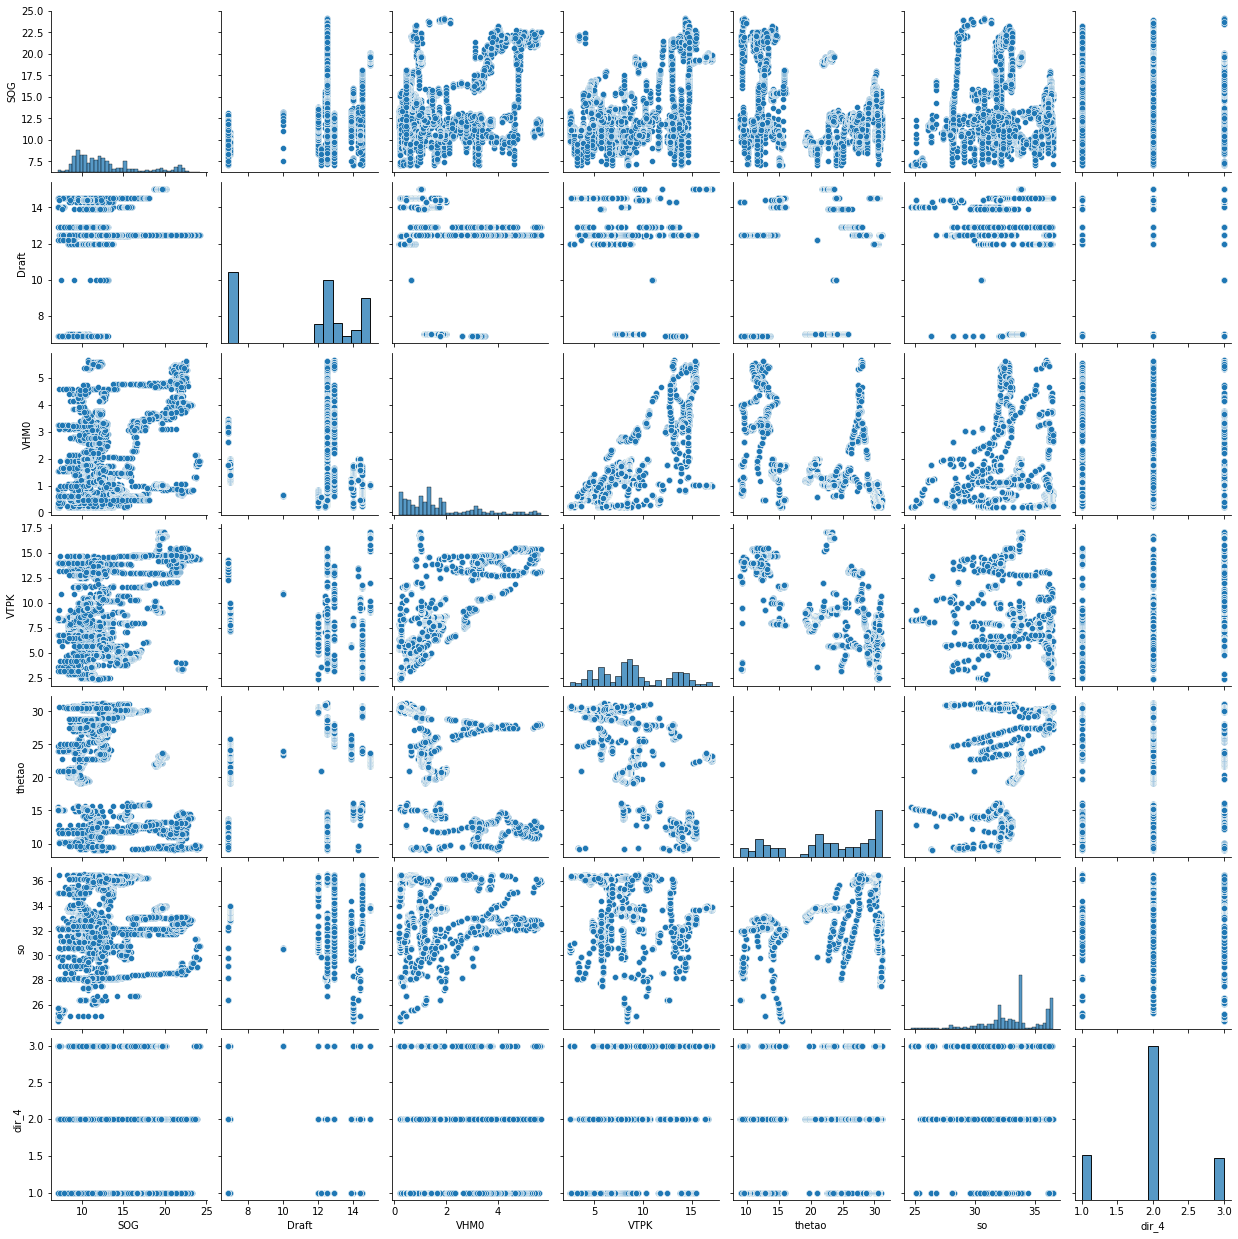

In [ ]:
import seaborn as sns
subset = ["SOG", "Draft", "VHM0", "VTPK", "thetao", "so", "dir_4"]
sns.pairplot(df[subset])

In [ ]:
'''
# prepare dataframe
df = df.copy()
df = df.dropna()

# normalize
df=(df-df.min())/(df.max()-df.min()) # normalize min max

# standardize
df=(df-df.mean())/df.std()
df = df.drop(df[df.SOG > 5].index)

df[df.SOG > 3]
df
'''

'\n# prepare dataframe\ndf = df.copy()\ndf = df.dropna()\n\n# normalize\ndf=(df-df.min())/(df.max()-df.min()) # normalize min max\n\n# standardize\ndf=(df-df.mean())/df.std()\ndf = df.drop(df[df.SOG > 5].index)\n\ndf[df.SOG > 3]\ndf\n'

In [ ]:
# Select features and target variable
# subset = ["VMDR", "VTM10", "VTPK", "VPED", "VMDR_WW", "VHM0_SW1", "VTM01_SW1", "VSDX", "VHM0", "uo"]
subset = ["Draft", "VHM0", "VTPK", "thetao", "so", "dir_4"]
X = df[subset].copy()
y = df["SOG"].copy()

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [ ]:
# Build DT model and finetune
rt = DecisionTreeRegressor(criterion = "mse")#, max_depth=10)
rt

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
from time import process_time

Elapsed time in seconds:  0.018688215999986824
R2:  0.9915090682820358

VTPK 0.4695330687784015
Draft 0.21741496327070264
thetao 0.1405506623984939
VHM0 0.13459869618089224
so 0.031457895492261
dir_4 0.006444713879248805


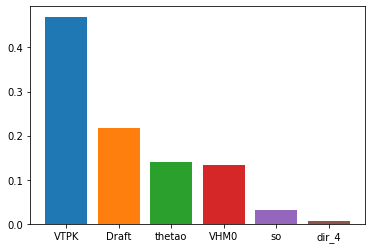

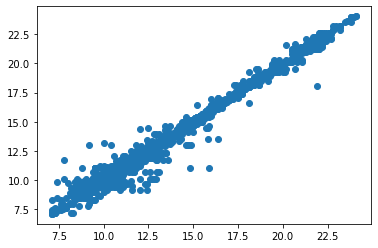

In [ ]:
# Train DT model
t_start = process_time()
model_dt = rt.fit(X_train, y_train)
t_stop = process_time()

time_dt = t_stop-t_start
print("Elapsed time in seconds: ", time_dt)

r2_dt = model_dt.score(X_test, y_test)
print("R2: ", r2_dt)

print("")
# importance of independent variables for decision tree regression model
for importance, name in sorted(zip(rt.feature_importances_, X_train.columns),reverse=True):
 print (name, importance)
 pyplot.bar(name, importance)

pyplot.show()

y_pred = model_dt.predict(X_test)
plt.scatter(y_test, y_pred)

In [ ]:
# Evaluate
y_pred = model_dt.predict(X_test)
print("R Squared Score is:", metrics.r2_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R Squared Score is: 0.9914999969429158
Mean Absolute Error: 0.17521228317319978
Mean Squared Error: 0.13059832892193565
Root Mean Squared Error: 0.3613839079454641


Elapsed time in seconds:  0.003909389000000374
R2:  0.5500261582388559

Draft 0.8187862985286386
so 0.3841474580843436
VTPK 0.24558167114766657
VHM0 0.1817732369731755
dir_4 0.09191151354443565
thetao -0.22910194881705234


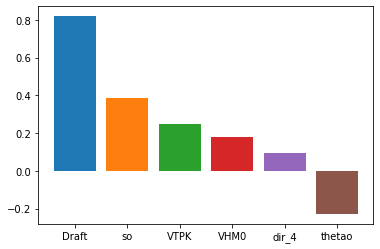

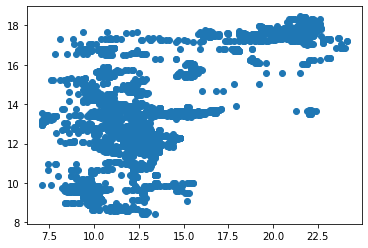

In [ ]:
# Linear Regression
lr = LinearRegression()

t_start = process_time()
model_lr = lr.fit(X_train, y_train)
t_stop = process_time()

time_lr = t_stop-t_start
print("Elapsed time in seconds: ", time_lr)

r2_lr = model_lr.score(X_test, y_test)
print("R2: ", r2_lr)

print("")
# importance of independent variables for linear regression model
for importance, name in sorted(zip(lr.coef_, X_train.columns),reverse=True):
 print (name, importance)
 pyplot.bar(name, importance)

pyplot.show()

y_pred = model_lr.predict(X_test)
plt.scatter(y_test, y_pred)

Elapsed time in seconds:  62.51191955500002
R2:  0.9908438379743372

Draft 0.3423396200513214
thetao 0.20198010496636684
VHM0 0.163493616482043
VTPK 0.16202155295310308
so 0.07131683157861364
dir_4 0.058848273968552044


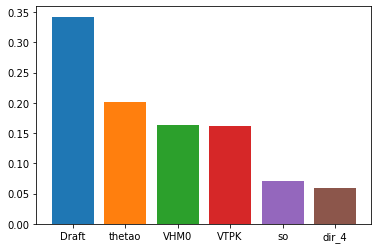

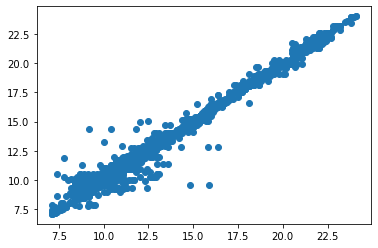

In [ ]:
# Extra Tree Regression
et = ExtraTreesRegressor(criterion = "mae")

t_start = process_time()
model_et = et.fit(X_train, y_train)
t_stop = process_time()

time_et = t_stop-t_start
print("Elapsed time in seconds: ", time_et)

r2_et = model_et.score(X_test, y_test)
print("R2: ", r2_et)

print("")
# importance of independent variables for extra tree regression model
for importance, name in sorted(zip(et.feature_importances_, X_train.columns),reverse=True):
 print (name, importance)
 pyplot.bar(name, importance)

pyplot.show()

y_pred = model_et.predict(X_test)
plt.scatter(y_test, y_pred)

# Save Model

In [ ]:
 from joblib import dump, load
# dump(model_dt, '/content/drive/MyDrive/Uni/StudyProject_CMS/data/DTR_model_final.joblib') 
dump(model_dt, '/content/drive/MyDrive/StudyProject_CMS/data/DTR_model_final.joblib') 
#  dump(model_r, 'DTR_model.joblib') 

['/content/drive/MyDrive/StudyProject_CMS/data/DTR_model_final.joblib']

# Predict SOG (Outdated)

In [ ]:
wms = WebMapService('https://nrt.cmems-du.eu/thredds/wms/global-analysis-forecast-wav-001-027', version='1.3.0')

In [ ]:
print(wms.identification.type)
print(wms.identification.version)
print(wms.identification.title)
print(wms.identification.abstract)
print(list(wms.contents))

WMS
1.3.0
CMEMS DU
Scientific Data
['VHM0', 'VMDR_WW', 'VHM0_WW', 'VMDR_SW1', 'VTM01_SW1', 'VMDR_SW2', 'VTM01_SW2', 'VMDR', 'VTM10', 'VHM0_SW1', 'VHM0_SW2', 'VTPK', 'VSDX', 'VSDY', 'VPED', 'VTM02', 'VTM01_WW']


In [ ]:
layer = 'VHM0'
print(wms[layer].title)
print(wms[layer].queryable)
print(wms[layer].opaque)
print(wms[layer].boundingBox)
print(wms[layer].boundingBoxWGS84)
print(wms[layer].crsOptions)
print(wms[layer].styles)

sea_surface_wave_significant_height
1
0
(-180.0, -80.0, 179.91666666666663, 90.0, 'CRS:84')
(-180.0, -80.0, 179.91666666666663, 90.0)
['EPSG:41001', 'EPSG:32661', 'EPSG:900913', 'EPSG:3408', 'EPSG:4258', 'EPSG:3857', 'EPSG:27700', 'EPSG:32761', 'EPSG:3409', 'EPSG:4326', 'CRS:84']
{'boxfill/rainbow': {'title': 'boxfill/rainbow', 'legend': 'http://nrt.cmems-du.eu/thredds/wms/global-analysis-forecast-wav-001-027?REQUEST=GetLegendGraphic&LAYER=VHM0&PALETTE=rainbow', 'legend_width': '110', 'legend_height': '264', 'legend_format': 'image/png'}, 'boxfill/occam': {'title': 'boxfill/occam', 'legend': 'http://nrt.cmems-du.eu/thredds/wms/global-analysis-forecast-wav-001-027?REQUEST=GetLegendGraphic&LAYER=VHM0&PALETTE=occam', 'legend_width': '110', 'legend_height': '264', 'legend_format': 'image/png'}, 'boxfill/redblue': {'title': 'boxfill/redblue', 'legend': 'http://nrt.cmems-du.eu/thredds/wms/global-analysis-forecast-wav-001-027?REQUEST=GetLegendGraphic&LAYER=VHM0&PALETTE=redblue', 'legend_width

In [ ]:
# Methods

print([op.name for op in wms.operations])
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)

['GetCapabilities', 'GetMap', 'GetFeatureInfo']
[{'type': 'Get', 'url': 'http://nrt.cmems-du.eu/thredds/wms/global-analysis-forecast-wav-001-027'}]
['image/png', 'text/xml']


In [ ]:
# Download data

img = wms.getmap(layers=['VHM0'],
                 styles=['boxfill/occam'],
                 srs='EPSG:4326',
                 bbox=(-180.0, -80.0, 179.916, 90.0),
                 size=(300, 250),
                 format='image/png',
                )
out = open('global-analysis-forecast-wav-001-027_VHM0.png', 'wb')
out.write(img.read())
out.close()

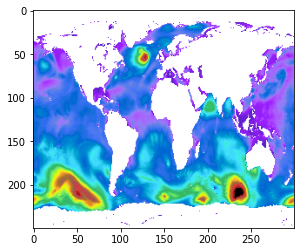

In [ ]:
plt.imshow(mpimg.imread('global-analysis-forecast-wav-001-027_VHM0.png'));

# TODO
## not deleted to use maybe for report
- Perhaps use data for just one ship...
- Larger dataset!
  - And / or larger period of time
  - Remove small SOG (just use > 7)
  - Specific length / width
- Normalize data!
  - Even better to standardize the data
- Model relative direction
  - Diversion of Heading vs. COG
    - Difference COG and Heading
      - course cardinal direction in which the craft is to be steered. 
      - Heading is the compass direction in which the craft's bow or nose is pointed.
- Convert directions
- Remove outliers: normalized values larger than ±5
- Transfer model to grid to use for routing
- Get larger dataset
  - Filter specific type of ship
- Research on regression / modelling methods

## Open questions
- How to translate model in to grid
  - Based on (more or less) live data?
- How many datasets did they use for the example paper?




Meeting 09.07.21

*   perhaps focus on data from one single ship 
*   perhaps less amount of data
*   dataset to small (better a bit bigger) 
*   exclude all values of small SOG (higher than 5, but porpably better 7 to gurantee that there are no restirictions due to traffic on the ship routes)
*   specific height and width of the ship 
*   standarize the dataset (How exactly?)

